In [ ]:
%%capture
!pip install mordred
!pip install rdkit-pypi

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, AllChem

import mordred
from mordred import Calculator, descriptors

import pandas as pd
from tqdm import tqdm

In [ ]:
df = pd.read_excel('alcohols.xlsx')

In [ ]:
df.head()

,Name,Smiles
0,2-phenoxyethanol,OCCOC1=CC=CC=C1
1,2-bromoethanol,BrCCO
2,2-fluoroethanol,FCCO
3,methanol,CO
4,benzylalcohol,OCC1=CC=CC=C1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    100 non-null    object
 1   Smiles  100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


## **Generate molecular objects from SMILES with hydrogens attached**

In [ ]:
mol_list = []

for smile in df['Smiles']:
  mol = Chem.MolFromSmiles(smile)
  mol = Chem.AddHs(mol)
  mol_list.append(mol)

df = pd.concat([df, pd.DataFrame(mol_list, columns = (['Mol']))], axis=1)


In [ ]:
df.head()

,Name,Smiles,Mol
0,2-phenoxyethanol,OCCOC1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x7b1b72211310>
1,2-bromoethanol,BrCCO,<rdkit.Chem.rdchem.Mol object at 0x7b1b722111c0>
2,2-fluoroethanol,FCCO,<rdkit.Chem.rdchem.Mol object at 0x7b1b72211ee0>
3,methanol,CO,<rdkit.Chem.rdchem.Mol object at 0x7b1b72211460>
4,benzylalcohol,OCC1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x7b1b722115b0>


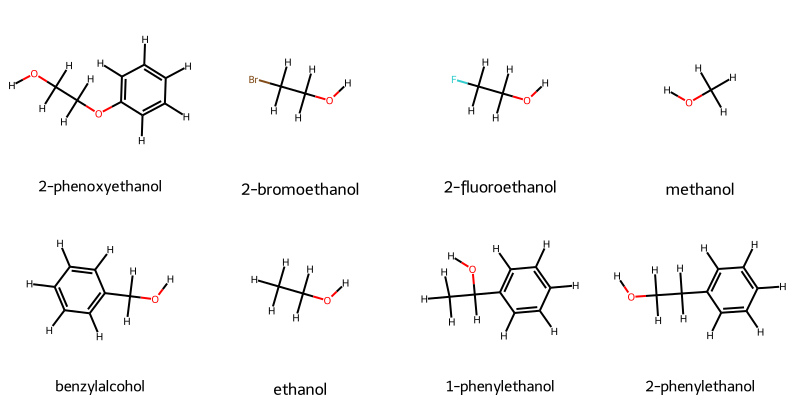

In [ ]:
Draw.MolsToGridImage(df['Mol'][:8],molsPerRow=4,subImgSize=(200,200),legends=[x for x in df['Name'][:8]])


**Create calculator object to calculate descriptors**

In [ ]:
# Creating a descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=False)

In [ ]:
calc

In [ ]:
# calc.descriptors contains all the descriptor classes
print(calc.descriptors)

(mordred.ABCIndex.ABCIndex(), mordred.ABCIndex.ABCGGIndex(), mordred.AcidBase.AcidicGroupCount(), mordred.AcidBase.BasicGroupCount(), mordred.AdjacencyMatrix.AdjacencyMatrix('SpAbs'), mordred.AdjacencyMatrix.AdjacencyMatrix('SpMax'), mordred.AdjacencyMatrix.AdjacencyMatrix('SpDiam'), mordred.AdjacencyMatrix.AdjacencyMatrix('SpAD'), mordred.AdjacencyMatrix.AdjacencyMatrix('SpMAD'), mordred.AdjacencyMatrix.AdjacencyMatrix('LogEE'), mordred.AdjacencyMatrix.AdjacencyMatrix('VE1'), mordred.AdjacencyMatrix.AdjacencyMatrix('VE2'), mordred.AdjacencyMatrix.AdjacencyMatrix('VE3'), mordred.AdjacencyMatrix.AdjacencyMatrix('VR1'), mordred.AdjacencyMatrix.AdjacencyMatrix('VR2'), mordred.AdjacencyMatrix.AdjacencyMatrix('VR3'), mordred.Aromatic.AromaticAtomsCount(), mordred.Aromatic.AromaticBondsCount(), mordred.AtomCount.AtomCount('Atom'), mordred.AtomCount.AtomCount('HeavyAtom'), mordred.AtomCount.AtomCount('Spiro'), mordred.AtomCount.AtomCount('Bridgehead'), mordred.AtomCount.AtomCount('Hetero'), m

In [ ]:
# print the names of descriptors
all_descriptor_names = [desc.__class__.__name__ for desc in calc.descriptors]
print(all_descriptor_names[:20])

['ABCIndex', 'ABCGGIndex', 'AcidicGroupCount', 'BasicGroupCount', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AromaticAtomsCount', 'AromaticBondsCount', 'AtomCount', 'AtomCount']


In [ ]:
# Checking the length of descriptors in the calculator
len(all_descriptor_names)

1826

**Calculate one 3D descriptor for a sinlge molecule**

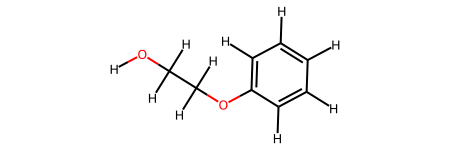

In [ ]:
df['Mol'][0]

In [ ]:
generate_3d_coordinates(df['Mol'][0])

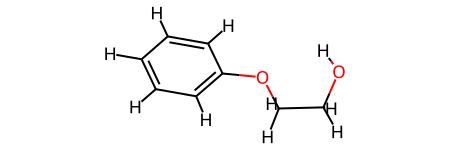

In [ ]:
df['Mol'][0]

In [ ]:
# Calculating descriptors for a single molecule
dia = mordred.GeometricalIndex.Diameter3D()

dia(df['Mol'][0])

8.284303054319427

**Calculate 2D/3D descriptors for the whole dataset**

In [ ]:
# Function to generate 3D coordinates using RDKit
def generate_3d_coordinates(molecule):
    AllChem.EmbedMolecule(molecule)
    AllChem.MMFFOptimizeMolecule(molecule)

# Iterate through molecules
d = []
for mol in tqdm(df['Mol']):
  generate_3d_coordinates(mol)

 # Calculate descriptors
  result = calc(mol)
  d.append(result)


final_df = pd.concat([df[['Name', 'Smiles']], pd.DataFrame(d, columns = (str(key) for key in result.keys()))], axis=1)

100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


In [ ]:
final_df.head()

,Name,Smiles,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,2-phenoxyethanol,OCCOC1=CC=CC=C1,7.071068,6.54776,0,0,12.932143,2.154341,4.308683,12.932143,...,8.438366,38.130322,138.068080,6.903404,133,9,42.0,44.0,3.111111,2.50
1,2-bromoethanol,BrCCO,2.121320,2.34010,0,0,4.472136,1.618034,3.236068,4.472136,...,5.509388,22.328143,123.952377,13.772486,10,1,10.0,8.0,2.500000,1.25
2,2-fluoroethanol,FCCO,2.121320,2.34010,0,0,4.472136,1.618034,3.236068,4.472136,...,5.509388,22.328143,64.032443,7.114716,10,1,10.0,8.0,2.500000,1.25
3,methanol,CO,0.000000,0.00000,0,0,2.000000,1.000000,2.000000,2.000000,...,1.098612,7.493061,32.026215,5.337702,1,0,2.0,1.0,2.000000,1.00
4,benzylalcohol,OCC1=CC=CC=C1,5.656854,5.42766,0,0,10.424292,2.135779,4.271558,10.424292,...,8.298291,35.247635,108.057515,6.753595,64,7,34.0,36.0,2.611111,2.00


In [ ]:
final_df['GRAV']

0     1351.602791
1      674.725928
2      392.330434
3       95.875740
4      975.368716
         ...     
95    1729.029741
96    1680.126157
97    1392.167308
98    1744.348835
99    2740.355586
Name: GRAV, Length: 100, dtype: float64

# **Generate two 3d descriptors for the whole dataset.**


In [ ]:
# Function to generate 3D coordinates using RDKit
def generate_3d_coordinates(molecule):
    AllChem.EmbedMolecule(molecule)
    AllChem.MMFFOptimizeMolecule(molecule)

# # Create a calculator with 3D descriptors
mor = mordred.MoRSE.MoRSE(prop=None, distance=7) #Mor07
dia = mordred.GeometricalIndex.Diameter3D() # GeomDiameter

# # Iterate through molecules
d = []
for mol in df['Mol']:
  desc = []
  generate_3d_coordinates(mol)

 # Calculate descriptors
  desc.append(mor(mol))
  desc.append(dia(mol))
  d.append(desc)

# Create a dataframe
final_df = pd.concat([df[['Name', 'Smiles']], pd.DataFrame(d, columns = (['Mor07', 'Diameter3D']))], axis=1)

In [ ]:
final_df.head()

,Name,Smiles,Mor07,Diameter3D
0,2-phenoxyethanol,OCCOC1=CC=CC=C1,2.279734,8.254762
1,2-bromoethanol,BrCCO,0.045055,4.408331
2,2-fluoroethanol,FCCO,0.453883,4.280613
3,methanol,CO,-0.174211,2.842919
4,benzylalcohol,OCC1=CC=CC=C1,2.074889,6.022029
